## Introdução
Neste exemplo iremos fazer um classficador de imagens usando redes neurais desde o inicio. 
Para isso usaremos a base de dados Cats vs Dogs do Kaggle. 


## Setup


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Carregando os dados

### Dados originais


In [13]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   236M      0  0:00:03  0:00:03 --:--:--  236M


In [14]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

 kagglecatsanddogs_3367a.zip  'MSR-LA - 3467.docx'  'readme[1].txt'
 model.png		       PetImages	     sample_data


Agora temos uma pasta com o nome `PetImages` que contém dois subdiretorios `Cat` and `Dog`. Cada diretório contem imagens de cada classe. 

In [15]:
!ls PetImages


Cat  Dog


### Filtrando imagens corrompidas

Quando trabalhamos com muitas imagens, é comum encontrarmos imagens que estão corrompidas. 
Vamos filtrar imagens mal codificadas que não apresentam a seqüência "JFIF" em seu cabeçalho.


In [16]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Gerando um base de dados


In [17]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

## Visualizando os dados

Aqui estão as primeiras 9 imagens do conjunto de dados de treinamento. Como você pode ver, o rótulo 1 é "cão".
 e o rótulo 0 é "gato".


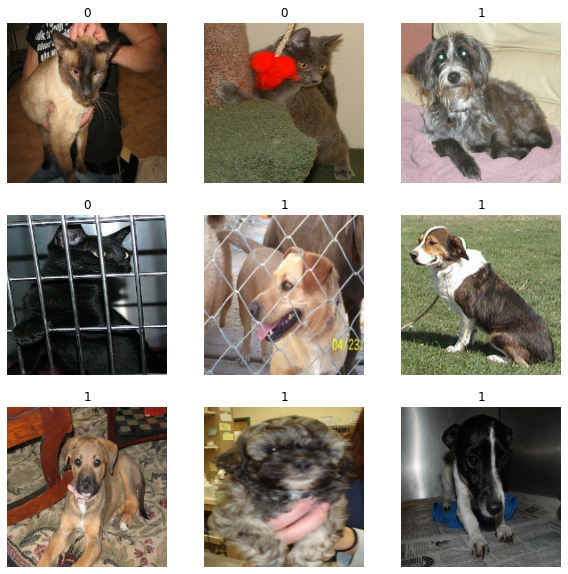

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


Quando você não tem um grande conjunto de dados de imagem, é uma boa prática para artificialmente
introduzir a diversidade de amostras, aplicando transformações aleatórias, porém realistas, ao
imagens de treinamento, tais como a rotação horizontal aleatória ou pequenas rotações aleatórias. Este
ajuda a expor o modelo a diferentes aspectos dos dados de treinamento, ao mesmo tempo em que diminui a velocidade
 overfitting.



In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Vamos visualizar como são as amostras aumentadas, aplicando `data_augmentation`.
 repetidamente até a primeira imagem no conjunto de dados:

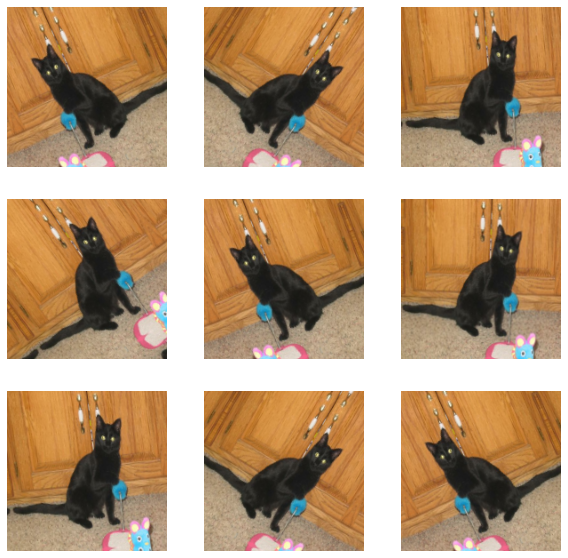

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Padronizando os dados

Nossas imagens já estão em um tamanho padrão (180x180). No entanto, seus valores de canal RGB estão em
 o intervalo `[0, 255]`. Isto não é ideal para uma rede neural;
em geral, você deve procurar fazer com que seus valores de entrada sejam pequenos. Aqui, nós vamos
padronizar os valores a serem colocados na camada "0, 1", utilizando uma camada "Rescaling" no início de
 nosso modelo.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

Com esta opção, seu aumento de dados acontecerá *no dispositivo*, de forma síncrona
com o resto da execução do modelo, o que significa que ele se beneficiará da GPU
 aceleração.

Observe que o aumento de dados está inativo no momento do teste, portanto, as amostras de entrada serão apenas
 aumentado durante `fit()`, não ao chamar `evaluate()` ou `predict()`.

Se você estiver treinando na GPU, esta é a melhor opção.


**Opção 2: aplicá-lo ao conjunto de dados**, de modo a obter um conjunto de dados que produza lotes de
 imagens ampliadas, como esta:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

Com esta opção, seu aumento de dados acontecerá **na CPU**, de forma assíncrona, e
 ser tamponado antes de entrar no modelo.

Se você estiver treinando em CPU, esta é a melhor opção, já que faz o aumento de dados
 assíncrono e não obstrutivo.

Em nosso caso, vamos com a primeira opção.


## Configurar o conjunto de dados para o desempenho


In [27]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Construir um modelo

Vamos construir uma pequena versão da rede Xception. Nós não tentamos particularmente otimizar a arquitetura; se você quiser fazer uma busca sistemática pelo melhor modelo considerar o uso de [KerasTuner](https://github.com/keras-team/keras-tuner).

Note que:

- Iniciamos o modelo com o pré-processador `data_augmentation`, seguido por um
 Camada "Rescaling".
- Incluímos uma camada de 'dropout' antes da camada de classificação final.

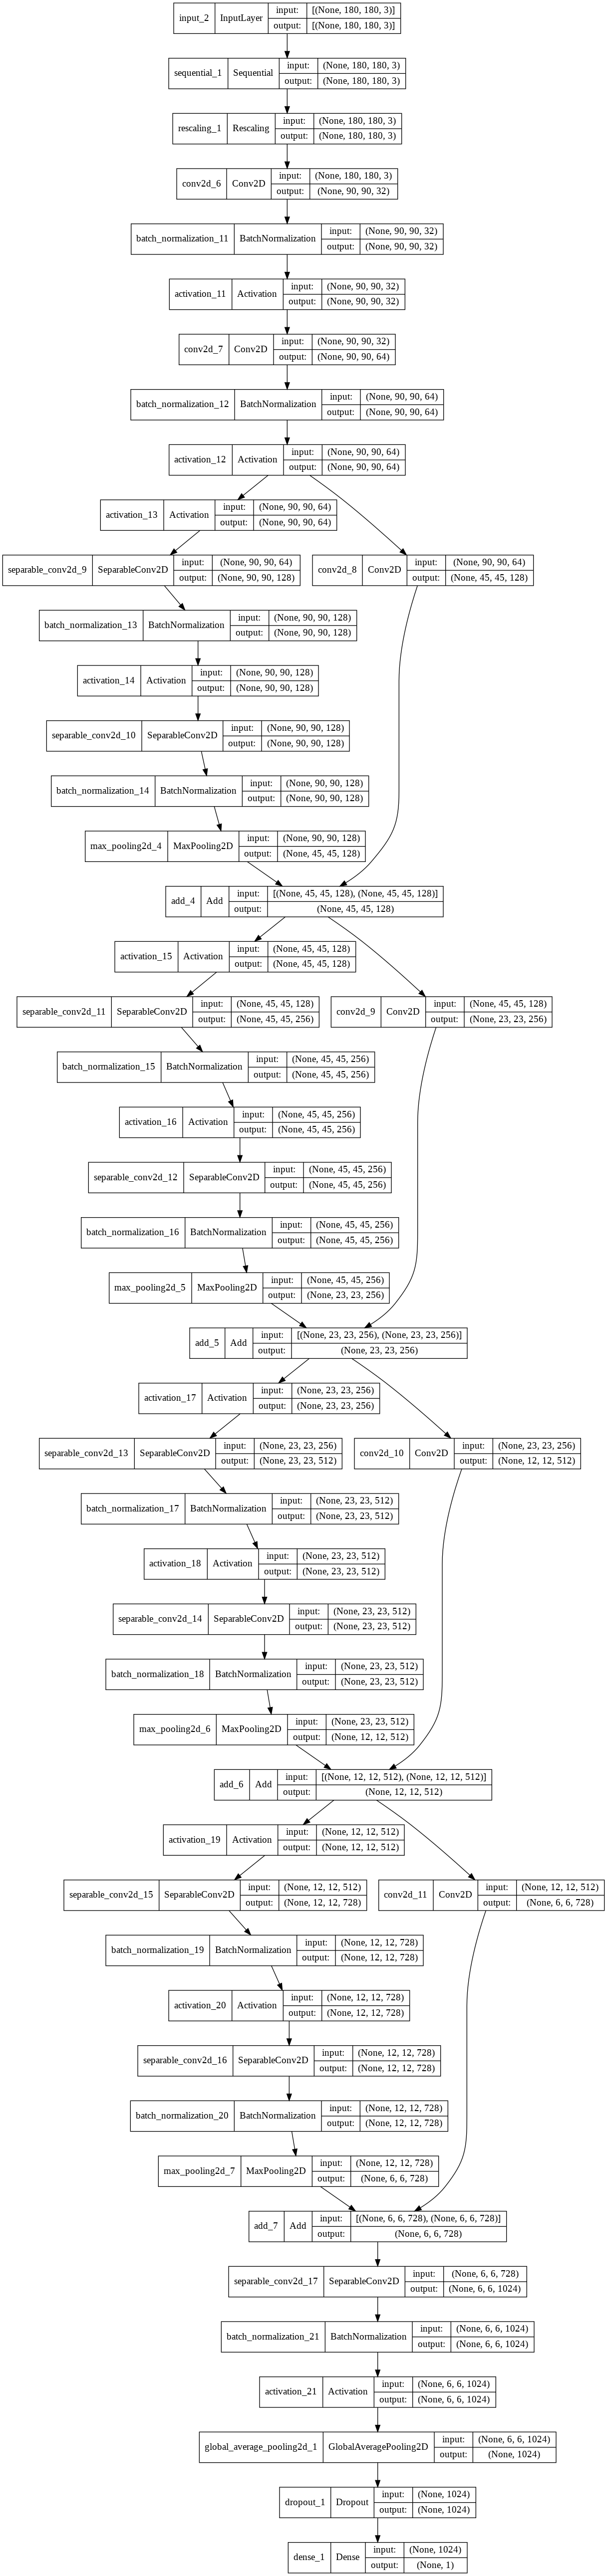

In [28]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## treinando o modelo


In [ ]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


 11/586 [..............................] - ETA: 48:16 - loss: 0.9013 - accuracy: 0.5739

## Executar inferência sobre novos dados

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
